In [72]:
# installing yahoo finance library
!pip install yfinance


In [73]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [74]:
# importing libraries
import yfinance as yf

# importing USD-JPY data
usd_jpy_df = yf.download('USDJPY=X', start='1996-10-30', end='2024-08-29')
usd_jpy_df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-10-30,114.370003,114.480003,113.610001,114.180000,114.180000,0
1996-11-01,113.500000,113.500000,113.500000,113.500000,113.500000,0
1996-11-04,113.279999,113.980003,112.949997,113.879997,113.879997,0
1996-11-05,113.709999,114.330002,113.449997,114.250000,114.250000,0
1996-11-06,114.230003,114.680000,113.650002,113.949997,113.949997,0


In [75]:
# From here we can see that on average yen value was 111.5, and it was min 75 yen.73 per usd, highest was 161.2
usd_jpy_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,7218.000000,7218.000000,7218.000000,7218.000000,7218.000000,7218.0
mean,111.594651,112.050878,111.095597,111.589815,111.589815,0.0
std,16.040874,16.123239,15.955976,16.040775,16.040775,0.0
min,75.750000,75.973999,75.570000,75.739998,75.739998,0.0
25%,104.322500,104.806999,103.900501,104.316002,104.316002,0.0
50%,110.992496,111.407001,110.586502,110.999500,110.999500,0.0
75%,119.856001,120.349998,119.297503,119.848000,119.848000,0.0
max,161.621002,161.942001,161.300003,161.621002,161.621002,0.0


In [76]:
# We can see that there are no null values
usd_jpy_df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Text(0.5, 1.0, 'Historical relationship between Yen/USD')

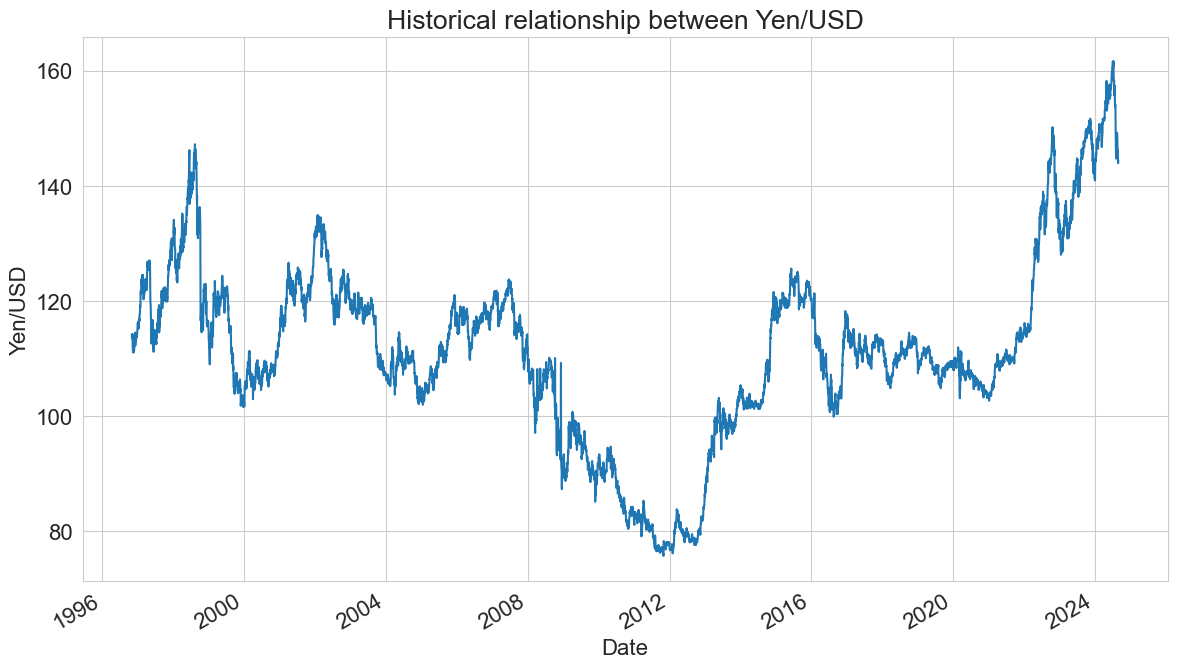

In [77]:
usd_jpy_df['Close'].plot()
plt.ylabel('Yen/USD')
plt.title('Historical relationship between Yen/USD')

In [78]:
from statsmodels.tsa.stattools import adfuller

adfuller(usd_jpy_df['Close'])[1]  # p-value

0.5522395324429307

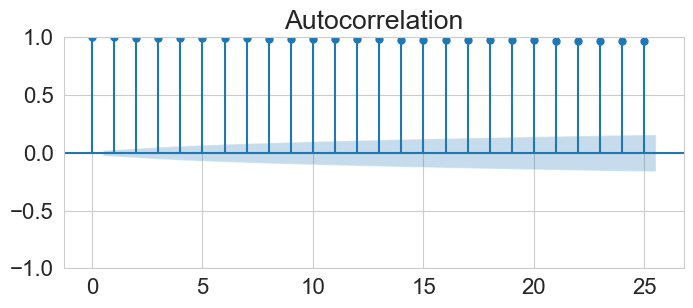

In [79]:
fig, ax = plt.subplots(1,1, figsize=(8,3))
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(usd_jpy_df['Close'], lags=25, ax=ax)
plt.show()

In [80]:
usd_jpy_df['Day_of_week'] = usd_jpy_df.index.dayofweek
usd_jpy_df['Month'] = usd_jpy_df.index.month
usd_jpy_df.head()


,Open,High,Low,Close,Adj Close,Volume,Day_of_week,Month
Date,,,,,,,,
1996-10-30,114.370003,114.480003,113.610001,114.180000,114.180000,0,2,10
1996-11-01,113.500000,113.500000,113.500000,113.500000,113.500000,0,4,11
1996-11-04,113.279999,113.980003,112.949997,113.879997,113.879997,0,0,11
1996-11-05,113.709999,114.330002,113.449997,114.250000,114.250000,0,1,11
1996-11-06,114.230003,114.680000,113.650002,113.949997,113.949997,0,2,11


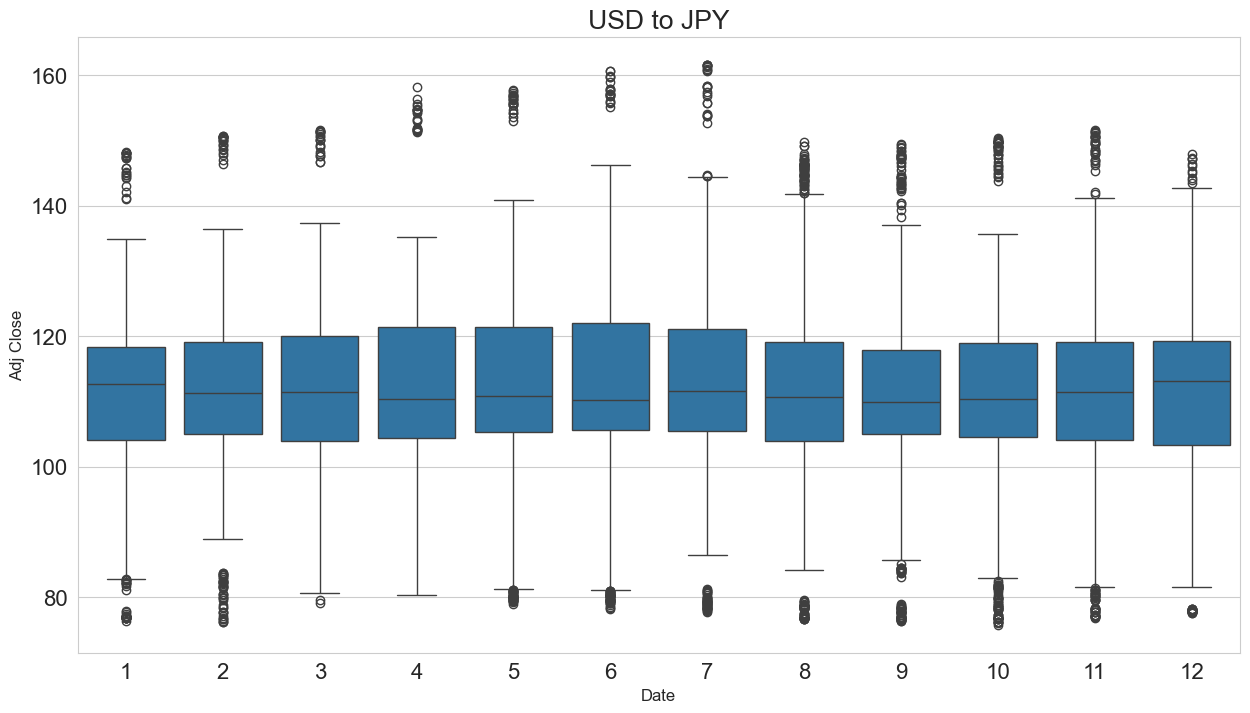

In [81]:
# Plotting Adj Close price against Month
plt.figure(figsize=(15,8))
plt.grid(True)
plt.title('USD to JPY')
sns.boxplot(x=usd_jpy_df['Month'], y=usd_jpy_df['Adj Close'])
plt.xlabel('Date', fontsize=12)
plt.ylabel('Adj Close', fontsize=12)
plt.show()

ACF and PACF Plot


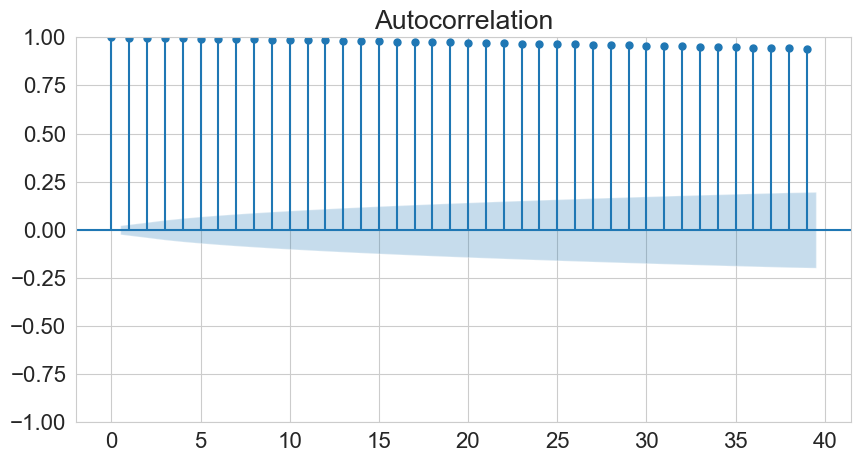

In [82]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

plt.rc("figure", figsize=(10,5))
plot_acf(usd_jpy_df['Adj Close'])
print()


We can see autocorrelation until 40 lag values

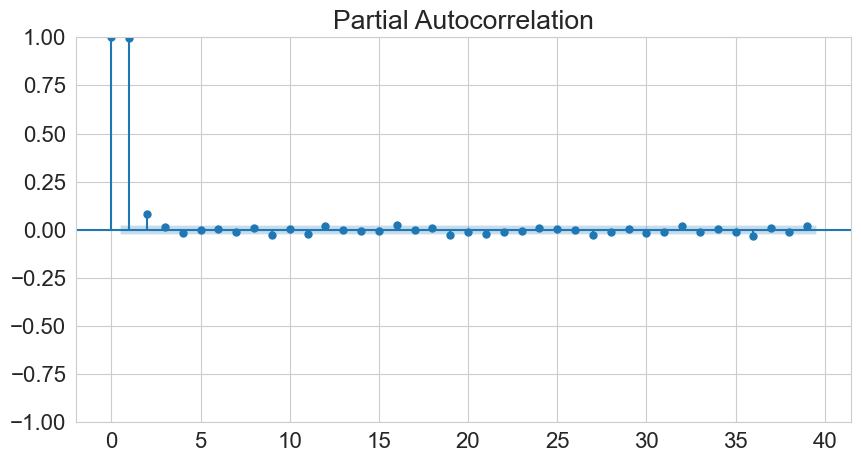

In [83]:
#Partial auto-correlation shows only few lag values are actually correlated.
plt.rc("figure", figsize=(10,5))
plot_pacf(usd_jpy_df['Adj Close'])
print()

📙 4. Price forecasting¶


In [84]:
data = usd_jpy_df['Adj Close'].values
print('Shape of data: ', data.shape)

Shape of data:  (7218,)


In [85]:
# Separate train and test data
train_length = int(len(data) * 0.8)
print('Train length: ', train_length)

train_data, test_data = data[:train_length], data[train_length:]
print('Shape of Train and Test data: ', len(train_data), len(test_data))

Train length:  5774
Shape of Train and Test data:  5774 1444


In [86]:
# split a univariate sequence into supervised learning [Input and Output]
from numpy import array
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [87]:
lag = 3  # Empirically we have choosen
n_features = 1

In [88]:
train_X, train_y = split_sequence(train_data, lag)
test_X, test_y = split_sequence(test_data, lag)

In [89]:
print('Shape of train_X and train_y: ', train_X.shape, train_y.shape)
print('Shape of test_X and test_y: ', test_X.shape, test_y.shape)

Shape of train_X and train_y:  (5771, 3) (5771,)
Shape of test_X and test_y:  (1441, 3) (1441,)


In [90]:
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], n_features))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))

In [91]:
# New shape of train_X and test_X are :-
print('Shape of train_X and train_y: ', train_X.shape, train_y.shape)
print('Shape of test_X and test_y: ', test_X.shape, test_y.shape)

Shape of train_X and train_y:  (5771, 3, 1) (5771,)
Shape of test_X and test_y:  (1441, 3, 1) (1441,)


In [92]:
#4.4 Define Model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [106]:
# define model
model = Sequential()
model.add(LSTM(16, activation='relu', return_sequences=False, input_shape=(lag, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 16)                1152      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


In [107]:
# fit model
history = model.fit(train_X, train_y, epochs = 25, batch_size=8, verbose=1, validation_split= 0.1)

Epoch 1/25
650/650 [==============================] - 1s 803us/step - loss: 1333.4896 - val_loss: 0.5517
Epoch 2/25
650/650 [==============================] - 0s 604us/step - loss: 1.2315 - val_loss: 0.6658
Epoch 3/25
650/650 [==============================] - 0s 665us/step - loss: 1.1328 - val_loss: 0.7993
Epoch 4/25
650/650 [==============================] - 0s 601us/step - loss: 1.2053 - val_loss: 0.4868
Epoch 5/25
650/650 [==============================] - 0s 599us/step - loss: 1.1374 - val_loss: 0.5090
Epoch 6/25
650/650 [==============================] - 0s 596us/step - loss: 1.1307 - val_loss: 0.9955
Epoch 7/25
650/650 [==============================] - 0s 591us/step - loss: 1.1705 - val_loss: 0.4630
Epoch 8/25
650/650 [==============================] - 0s 591us/step - loss: 1.1299 - val_loss: 0.7140
Epoch 9/25
650/650 [==============================] - 0s 591us/step - loss: 1.1572 - val_loss: 0.4520
Epoch 10/25
650/650 [==============================] - 0s 632us/step - loss: 1.

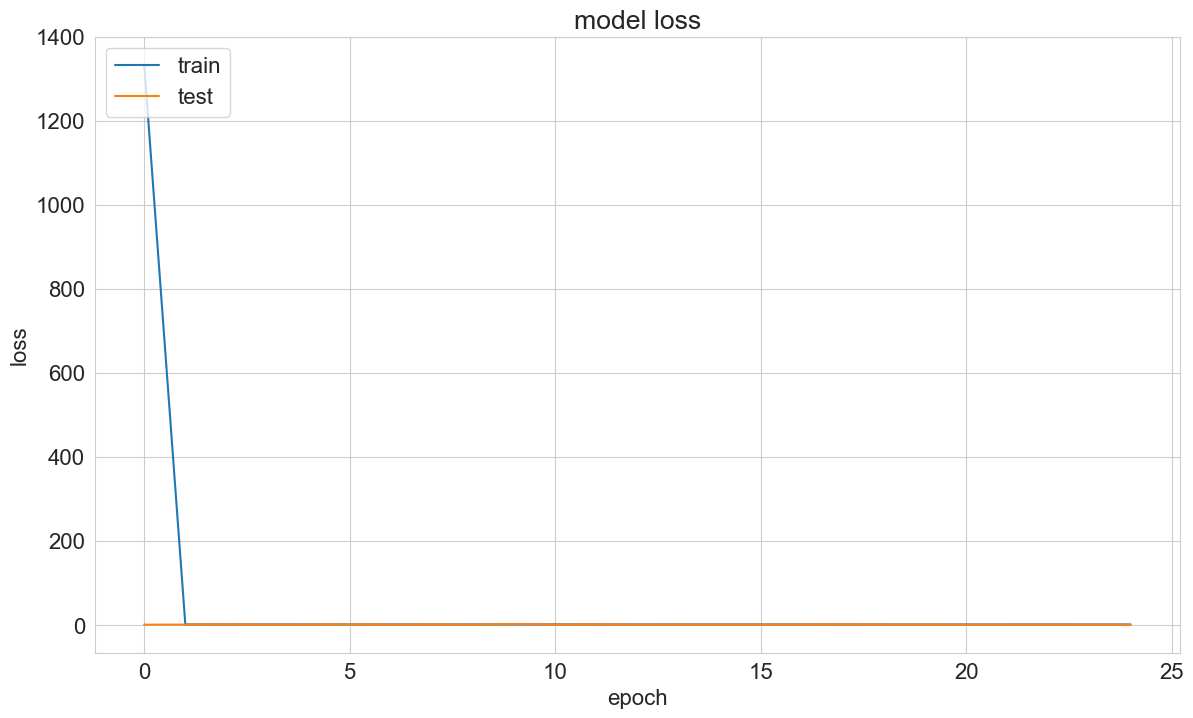

In [108]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [109]:
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

print('Shape of train and test predict: ', train_predict.shape, test_predict.shape)

46/46 [==============================] - 0s 297us/step
Shape of train and test predict:  (5771, 1) (1441, 1)


In [110]:
# root mean squared error or rmse
import math
from sklearn.metrics import mean_squared_error

def measure_rmse(actual, predicted):
    return math.sqrt(mean_squared_error(actual, predicted))

train_score = measure_rmse(train_y, train_predict)
test_score = measure_rmse(test_y, test_predict)

print('Train and Test RMSE: ', train_score, test_score)

Train and Test RMSE:  0.9723746567007923 0.8873163891344279


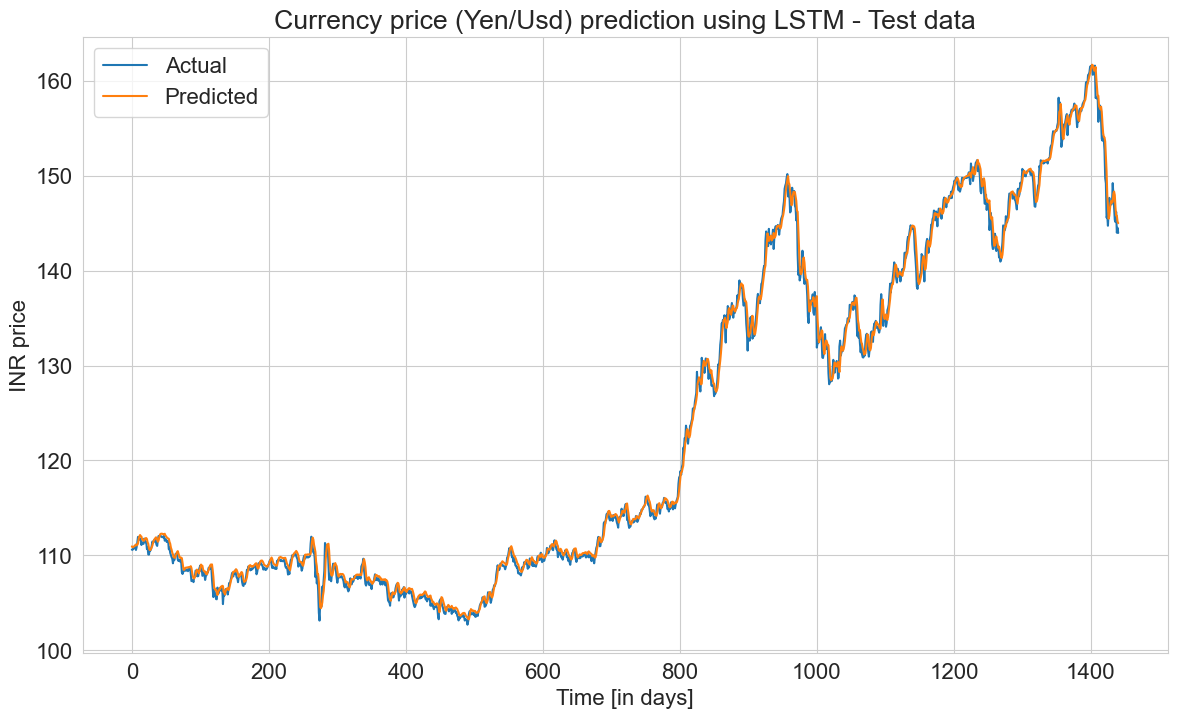

In [112]:
plt.rc("figure", figsize=(14,8))
plt.rcParams.update({'font.size': 16})
plt.plot(test_y, label = 'Actual')
plt.plot(test_predict, label = 'Predicted')
plt.xlabel('Time [in days]')
plt.ylabel('INR price')
plt.title('Currency price (Yen/Usd) prediction using LSTM - Test data')
plt.legend()
plt.show()

In [115]:
import numpy as np

# Assuming your model is already trained and 'model' is available

# Get the last sequence from your test data
last_sequence = test_X[-1]

# Initialize an array to store predictions
future_predictions = []

# Predict the next 10 days
for _ in range(10):
    # Reshape the last sequence to match the input shape of your model
    current_sequence = last_sequence.reshape((1, last_sequence.shape[0], last_sequence.shape[1]))

    # Make a prediction
    next_day_prediction = model.predict(current_sequence)

    # Append the prediction to our results
    future_predictions.append(next_day_prediction[0, 0])

    # Update the sequence by removing the first element and adding the prediction
    last_sequence = np.roll(last_sequence, -1, axis=0)
    last_sequence[-1] = next_day_prediction

# Convert to numpy array
future_predictions = np.array(future_predictions)

print("Shape of future predictions:", future_predictions.shape)
print("Future predictions for the next 10 days:", future_predictions)

1/1 [==============================] - 0s 8ms/step
Shape of future predictions: (10,)
Future predictions for the next 10 days: [145.0034  144.74841 144.94151 145.0754  145.11948 145.23303 145.3302
 145.41756 145.51509 145.60913]
